In [1]:
  !unzip /content/dataset-ar.zip

Archive:  /content/dataset-ar.zip
   creating: dataset-2/
dataset-2/Alkabah_الكعبة/:  mismatching "local" filename (dataset-2/Alkabah_╪з┘Д┘Г╪╣╪и╪й/),
         continuing with "central" filename version
   creating: dataset-2/Alkabah_الكعبة/
dataset-2/Almasa_المسعى/:  mismatching "local" filename (dataset-2/Almasa_╪з┘Д┘Е╪│╪╣┘Й/),
         continuing with "central" filename version
   creating: dataset-2/Almasa_المسعى/
dataset-2/Burj_Alsaah_برج_الساعة/:  mismatching "local" filename (dataset-2/Burj_Alsaah_╪и╪▒╪м_╪з┘Д╪│╪з╪╣╪й/),
         continuing with "central" filename version
   creating: dataset-2/Burj_Alsaah_برج_الساعة/
dataset-2/Jabal_Alnour_جبل_النور/:  mismatching "local" filename (dataset-2/Jabal_Alnour_╪м╪и┘Д_╪з┘Д┘Ж┘И╪▒/),
         continuing with "central" filename version
   creating: dataset-2/Jabal_Alnour_جبل_النور/
dataset-2/Maqam_Ibrahim_مقام_ابراهيم/:  mismatching "local" filename (dataset-2/Maqam_Ibrahim_┘Е┘В╪з┘Е_╪з╪и╪▒╪з┘З┘К┘Е/),
         continuing with "central" file

In [2]:

import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.4.1
Found GPU at: /device:GPU:0


In [3]:
# One Layer Seed model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import  SGD, RMSprop, Adam, Adadelta, Adagrad, Nadam

import tensorflow as tf
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#DATASET_DIR = "/content/dataset"
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
EPOCHS = 5
BATCH_SIZE = 4

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
##############
train_generator = train_datagen.flow_from_directory(
 '/content/'+'/dataset-2/',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')
##############
validation_generator = train_datagen.flow_from_directory(
    '/content/'+'/dataset-2/', 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    #shuffle= False,
    subset='validation')

##############
# ************

Found 770 images belonging to 6 classes.
Found 189 images belonging to 6 classes.


In [6]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
from keras.models import load_model

model = load_model("/content/image_my_h5_model.h5")

In [8]:
from keras.preprocessing.image import ImageDataGenerator

pred=model.predict(validation_generator,
steps=validation_generator.samples // BATCH_SIZE,
verbose=1)

47/47 [==============================] - 34s 58ms/step


In [9]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [10]:
!pip install flask_ngrok
!pip install flask_uploads
!pip install pip install werkzeug==0.16.0

  Created wheel for flask-uploads: filename=Flask_Uploads-0.2.1-cp37-none-any.whl size=8068 sha256=0114458a804cdb1098969fbe883ae089ef4fd7fb56af4a4b7ffb42032e933c2e
  Stored in directory: /root/.cache/pip/wheels/af/41/f6/0c357a43a5680e7690ce50337ab7fe9304795910ac10e15ce6
Successfully built flask-uploads
     |████████████████████████████████| 327kB 5.3MB/s 
  Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1


In [12]:
from werkzeug.utils import secure_filename
from werkzeug.datastructures import  FileStorage
from flask_uploads import UploadSet
from flask_uploads import configure_uploads
from flask_uploads import IMAGES
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from flask_ngrok import run_with_ngrok
import flask
from flask import Flask, render_template, request
model = load_model("/content/image_my_h5_model.h5")

In [13]:
app = flask.Flask(__name__, template_folder='/content')
run_with_ngrok(app)
#app = Flask(__name__)

photos = UploadSet('photos', IMAGES)

# path for saving uploaded images
app.config['UPLOADED_PHOTOS_DEST'] = './static/img'
configure_uploads(app, photos)

# professionals have standards :p
#@app.route('/home', methods=['GET', 'POST'])
#def home():
#   welcome = "Hello, World !"
#   return welcome

# the main route for upload and prediction
@app.route('/', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST' and 'photo' in request.files:
        # save the image
        filename = photos.save(request.files['photo'])
        # load the image
        path='./static/img/'+filename
        img = image.load_img(path, target_size=(224, 224))

        x = image.img_to_array(img)
        img1 = np.array(x).astype('float32')/255
        #img2 = transform.resize(img1, (224, 224))
        #x=np.expand_dims(x, axis=0)
        img = np.expand_dims(img1, axis=0)
        img = np.vstack([img])
        r = model.predict(img)

        names= dict((v,k) for k,v in labels.items())
        index = np.argmax(r)
        name=names.get(index)

        p=round(r.max()*100, 3)  #to find maximum score
        names= dict((v,k) for k,v in labels.items())
        value = np.argmax(r)

        # list out keys and values separately
        key_list = list(names.keys())
        val_list = list(names.values())
        # print key with val 100
        position = val_list.index(value)
        answer = " :صورة المعلم المدخله هي لـ"+ str(key_list[position])
        #plt.imshow(img1)
        return answer


    # web page to show before the POST request containing the image
    return render_template('upload.html')


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://1cc22fbe2353.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [05/Apr/2021 12:11:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 12:11:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [05/Apr/2021 12:11:58] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 12:13:05] "POST / HTTP/1.1" 200 -


صورة المعلم المدخله هي لـ:Alkabah_الكعبة


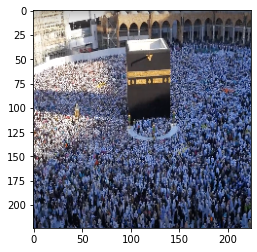

In [21]:
import numpy as np

#from google.colab import files
from keras.preprocessing import image

#uploaded=files.upload()

#for fn in uploaded.keys():
 
  # predicting images
path='/content/k28.png'
img=image.load_img(path, target_size=(224, 224))
  
x=image.img_to_array(img)
img1 = np.array(x).astype('float32')/255
  #img2 = transform.resize(img1, (224, 224))
  #x=np.expand_dims(x, axis=0)
img = np.expand_dims(img1, axis=0)
img = np.vstack([img])
r=model.predict(img)

names= dict((v,k) for k,v in labels.items())
index = np.argmax(r)
name=names.get(index)
p=round(r.max()*100, 3)  #to find maximum score
names= dict((v,k) for k,v in labels.items())
value = np.argmax(r)

  # list out keys and values separately
key_list = list(names.keys())
val_list = list(names.values())
  # print key with val 100
position = val_list.index(value)
print(f"صورة المعلم المدخله هي لـ:{key_list[position]}" )
plt.imshow(img1)

In [25]:
!pip install gtts
!pip install playsound
!pip install SpeechRecognition
!pip install gtts
from gtts import gTTS
import playsound 
import speech_recognition as sr

     |████████████████████████████████| 32.8MB 102kB/s 


# Speech Recognition

In [26]:
def speak(text):
    tt = gTTS( text = text , lang = "ar")
    filename = 'voice.mp3'
    tt.save(filename)
    playsound.playsound(filename)

In [28]:
if key_list[position] == 'برج_الساعه' :
    speak("ساعة مكة هي ساعة واقعة فوق مجمع أبراج البيت ضمن فندق فيرمونت بمدينة مكة المكرمة الواقعة غرب السعودية ، بارتفاع يزيد عن 600 متر لتكون أكبر ساعة في العالم، وقد بدأ تشغيلها في شهر رمضان من  عام ١٤٣١هـ تجريبيًّا، كما ربط مركز توقيت مكة المكرمة بشبكة التوقيت العالمي يو تو سي ومقرها في مدينة باريس ")

elif key_list[position] == 'مقام ابراهيم':
    speak("""\
    مقام إبراهيم هو حجر أثري قام عليه النبي إبراهيم عند رفع قواعد الكعبة وفقاً للعقيدة الإسلامية. وقد شُقّ عليه نتوء الحجارة حيث كان النبي إبراهيم يقوم عليه ويبني، وهو الحجر الذي قام من عليه بالأذان والنداء للحج بين الناس، وفي هذا الحجر أثر قدمي النبي إبراهيم، بعدما غاصت فيه قدماه، وهو الحجر التي تعرفه الناس اليوم عند الكعبة المشرفة، ويصلون خلفه ركعتي الطواف. 
وهو عبارة عن حجر مربع الشكل طوله نصف متر تقريباً لونه بين البياض والسواد والصفرة ومغطى حالياً بواجهة زجاجية عليها غطاء من النحاس من الخارج وأرضية رخامية، وهو حجر رخو من نوع حجر الماء غاصت فيه قدم النبي إبراهيم وبرزت فيه آثار قدميه، ولكن نتيجة لتمسح الناس فيه طمست ملامح القدم.
    """)
    
elif key_list[position] == 'المسعى':
    speak("""\
    الصَّفَا والمَرْوَةُ جبلان يقعان شرقي المسجد الحرام، ويعدان رمزان شهيران لشعيرة السعي .الصفا والمروة أكمة وسط مكة، تحيط بها بيوت أهل مكة وكان جبل الصفا متصلًا بجبل أبي قبيس والمروة متصلة بجبل قعيقعان، فلما جاءت التوسعة السعودية عام 1375 هـ قطعت جبل الصفا عن أصله جبل أبي قبيس، وأبقت على بعض الصخرات في نهايته علامة على موضع المشعر، وكذلك فعلت بالنسبة لجبل المروة، ولكن لوجود مستويين للحرم في جهة المروة أُحدث مدخلان: مدخل أعلى للدور الأعلى وهو مساو لارتفاع جبل المروة في اتجاه الصاعد، ومدخل في الأسفل بقي لاتصال المروة بأصله جبل قعيقعان.
يرجع بدء السعي بين الصفا والمروة إلى زمن النبي إبراهيم، حيث تعتبر هاجر أول من سعى بين الصفا والمروة، حينما كانت تلتمس الماء لابنها النبي إسماعيل، فكانت تصعد على جبل الصفا ثم تنزل حتى تصل جبل المروة، وقد كرَّرت ذلك سبعة أشواط، حتى وجدت الماء عند موضع زمزم، فشربت وأرضعت ولدها. فلما جاء الإسلام جعل ذلك من مناسك الحج والعمرة. الطريق الذي يربط بين الصفا والمروة يسمى مسعى، أو مكان السعي.
    
    """)
    
elif key_list[position] == 'Alkabah_الكعبة':
    speak("""\
    ُعد الكعبة المشرفة قبلة المسلمين في كل صلاة وهي أقدس بقعة على وجه الأرض، بُنيت الكعبة في البيت العتيق على يدي الرسولين إبراهيم واسماعيل عليهما السلام بأمر من الله تعالى. يبلغ طول الكعبة حين شُيدت حوالي 9 أذرع وغير مسقوفة. الكعبة المشرفة الآن يبلغ طولها 15 متراً، وهي أشبه بحجرة مسقفة في قلب البيت الحرام. أعيد ترميم و بناء الكعبة عدة مرات في التاريخ، منها بناء قريش في الجاهلية قبل الإسلام، ثم ترميم عبدالله بن الزبير لها، تلاها ترميم في العصر الأموي، ثم في عهد الدولة العثمانية، انتهاءً بالترميم في العصر الحديث في الدولة السعودية. داخل الكعبة المشرفة أربع جدران 
    
    """)
    
elif key_list[position] == 'جبل النور':
    speak("""\
    جبل النور هو أحد المواقع التاريخية في مكة المكرمة، سمّي بهذا الاسم نظراً لكون أنوار نبوة النبي محمد -صلى الله عليه وسلم- قد ظهرت أول ما ظهرت منه؛
اكتسب أهمية تاريخية لأن النبي محمد صلى الله عليه و سلم كان يخلو فيه بنفسه ليعبد الله قبل البعثة في غار حراء، وفيه نزل الوحي على النبي لأول مرة
    
    """)
elif key_list[position] == 'مسجد التنعيم':
    speak("""\
    مسجد التنعيم أو مسجد السيدة عائشة أحد مساجد مكة المكرمة، يقع في الجزء الغربي من مكة المكرمة على مسافة 7 كم عن الحرم المكي الشريف، ومنه يحرم أهالي مكة للحج والعمرة. اكتسب شهرته من كونه بُني في الموضع الذي أحرمت منه أم المؤمنين عائشة بنت أبي بكر بالعمرة في حجة الوداع سنة 9 للهجرة. حيث تم بنائه في عهد الخليفة المتوكل عام ٢٤٠هـ على مساحة 6 آلاف متر مربع، وتهدمت لاحقا معظم اجزائه ثم أُعيد بناؤه وتوسعة مساحته حتى اصبحت مساحته الإجمالية 84 ألف متر تشمل المرافق التابعة له.
    
    """)
    
else: 
    speak('نعتذر منك لاتوجد معلومات تخص معلمك في قاعدة بياناتنا')



ImportError: ignored